# Working with NAIP imagery in Python

Whitney DeLong, MGIS

INTRODUCTION:

The National Agricultural Imagery Program (NAIP) imagery is acquired during the agricultural growing season by the U.S. Department of Agriculture’s Farm Service Agency. For this exercise, 2017 NAIP imagery with red, green, blue, and near-infrared (R, G, B, NIR) bands was chosen. The NIR band is used to create a normalized difference vegetation index, or NDVI, that is very useful for classifying water, vegetation, and water-vegetation boundaries as it detects the presence of live green vegetation. As a part of a larger study using object-based image analysis to classify beaver impoundments along the North Shore of Lake Superior, a single study watershed shapefile was used to mask the NAIP image. Working with NAIP imagery in Python allows us to explore datasets, process and write new datasets, and visualize outputs efficiently. By writing a program instead of manually processing data, the steps can be repeated consistently and efficiently in the future. 

METHODS:

* Import all modules
* Explore NAIP image
    * View image
    * Check projection
    * Calculate summary statistics
* Mask NAIP image using shapefile of Kadunce River watershed and write masked output geotiff
* Create NDVI raster from masked NAIP image and write outout geotiff

CODE:

Import Modules:

In [2]:
# Import all modules used in this exercise. 

from osgeo import gdal
from pprint import pprint 
import matplotlib.pyplot as plt
import fiona
import rasterio
import numpy as np
#from rasterio.warp import calculate_default_transform, reproject, Resampling #revisit - might not use
from rasterio import crs 
from rasterio import plot
from rasterio.tools.mask import mask
#from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb

Explore Imagery:

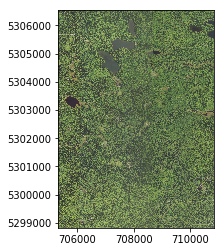

CRS({'init': 'epsg:26915'}) (NAD 1983 UTM Zone 15N)


In [6]:
# Let's first take a look at the NAIP image. 
file = "C:\\WMD_Projects\\GEOG5541\\INDV\\m_4709015_nw_15_1_20170825.tif"
NAIP = rasterio.open(file)

plot.show(NAIP)

# Check the projection of the NAIP image
print(NAIP.crs,"(NAD 1983 UTM Zone 15N)")

In [3]:
# Calculate summary statistics (minimum, maximum, mean, and median) for each of 4 bands in tiff NAIP image. 

NAIP = "C:\\WMD_Projects\\GEOG5541\\INDV\\m_4709015_nw_15_1_20170825.tif"
with rasterio.open(NAIP) as NAIP:
    array = NAIP.read()
    
# Create a list. 
stats = []
for band in array:
    # Append each statistic to the list as a dictionary with statistic and associated value as ordered pairs.
    stats.append({
        "min": band.min(),
        "mean": band.mean(),
        "median": np.median(band),
        "max": band.max() })
    
pprint(stats) 

[{'max': 228, 'mean': 96.9156967938893, 'median': 94.0, 'min': 32},
 {'max': 227, 'mean': 114.06591090721331, 'median': 114.0, 'min': 32},
 {'max': 226, 'mean': 75.71059349396334, 'median': 74.0, 'min': 31},
 {'max': 249, 'mean': 142.01626197354116, 'median': 148.0, 'min': 15}]


Mask NAIP image using shapefile:

In [4]:
# Mask NAIP image using Kadunce River watershed study area shapefile

NAIP = "C:\\WMD_Projects\\GEOG5541\\INDV\\m_4709015_nw_15_1_20170825.tif"
AOI = "C:\\WMD_Projects\\GEOG5541\\INDV\\Kadunce\\Kadunce.shp"
masked = "C:\\WMD_Projects\\GEOG5541\\INDV\\masked_NAIP.tif"

with fiona.open(AOI, "r") as AOI:
    geometry = [feature["geometry"] for feature in AOI]
    
with rasterio.open(NAIP) as NAIP:
    out_image, out_transform = mask(NAIP, geometry, crop=True)
    out_meta = NAIP.meta.copy()
    
out_meta.update ({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(masked, "w", **out_meta) as destination:
    destination.write(out_image)

Create NDVI:

In [5]:
# Preparing bands for creation of NDVI

# Open the file
file = "C:\\WMD_Projects\\GEOG5541\\INDV\\masked_NAIP.tif"
masked_NAIP = rasterio.open(file)

# Check to see that there are indeed 4 bands in NAIP image needed to calculate NDVI: 
print("Index of NAIP image showing bands present in image:",masked_NAIP.indexes)

# Name the bands in the NAIP image.
R= masked_NAIP.read(1)
G = masked_NAIP.read(2)
B = masked_NAIP.read(3)
NIR = masked_NAIP.read(4)

print("Example array showing layer values of Red (band 1):")
print(R)

Index of NAIP image showing bands present in image: (1, 2, 3, 4)
Example array showing layer values of Red (band 1):
[[  0   0   0 ... 147 147 144]
 [  0   0   0 ... 141 143 132]
 [  0   0   0 ... 131 144 135]
 ...
 [  0   0   0 ... 143 155 167]
 [  0   0   0 ... 156 156 165]
 [  0   0   0 ... 152 152 164]]


In [6]:
#Convert input arrays to floating point to avoid dividing by zero and create a better NDVI. 
R = R.astype(np.float32)
NIR = NIR.astype(np.float32)

In [7]:
# Function to create NDVI 
def NDVI(R, NIR):
    return ((NIR - R) / (NIR + R))

In [41]:
red = np.array(R)
print(Red)

[[  0.   0.   0. ... 147. 147. 144.]
 [  0.   0.   0. ... 141. 143. 132.]
 [  0.   0.   0. ... 131. 144. 135.]
 ...
 [  0.   0.   0. ... 143. 155. 167.]
 [  0.   0.   0. ... 156. 156. 165.]
 [  0.   0.   0. ... 152. 152. 164.]]


In [42]:
# Write NDVI to file

with rasterio.open(red) as red:
    source_crs = red.crs
    source_transform = red.transform
    
with rasterio.open("NDVI.tif", "w", driver = "GTiff",
                   height = NDVI.shape[0], # Number of rows
                   width = NDVI.shape[1], # Number of columns
                   count = 1, # Number of bands
                   dtype = rasterio.dtypes.float32, # Data type (must match array)
                   crs = source_crs, # Set projection same as source
                   transform = source_transform) as NDVI_raster: # Set transformation same as source
    NDVI_raster.write(NDVI,1)
    NDVI_raster.nodata = -1 

TypeError: invalid path: array([[  0.,   0.,   0., ..., 147., 147., 144.],
       [  0.,   0.,   0., ..., 141., 143., 132.],
       [  0.,   0.,   0., ..., 131., 144., 135.],
       ...,
       [  0.,   0.,   0., ..., 143., 155., 167.],
       [  0.,   0.,   0., ..., 156., 156., 165.],
       [  0.,   0.,   0., ..., 152., 152., 164.]], dtype=float32)

RESULTS:

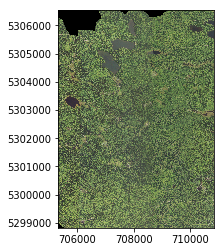

In [11]:
# Plot masked NAIP image
file = "C:\\WMD_Projects\\GEOG5541\\INDV\\masked_NAIP.tif"
masked_NAIP = rasterio.open(file)

plot.show(masked_NAIP)

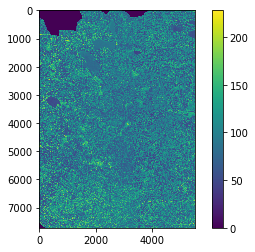

In [15]:
# Plot Red
plt.imshow(R)
plt.colorbar()

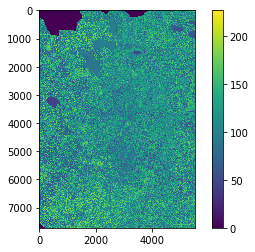

In [16]:
# Plot Green
plt.imshow(G)
plt.colorbar()

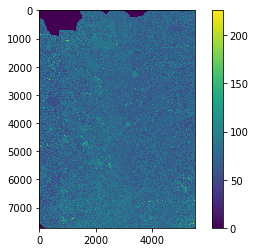

In [17]:
# Plot Blue
plt.imshow(B)
plt.colorbar()

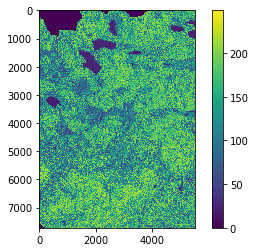

In [18]:
# Plot NIR
plt.imshow(NIR)
plt.colorbar()

C:\Users\Whitney DeLong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


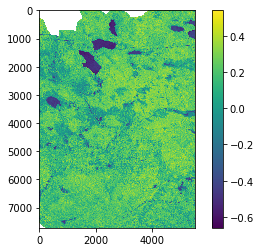

In [12]:
# Plot NDVI 
plt.imshow(NDVI(R, NIR))
plt.colorbar()

CONCLUSIONS:

write conclusions here

References:

https://mapbox.s3.amazonaws.com/playground/perrygeo/rasterio-docs/cookbook.html

https://geohackweek.github.io/raster/04-workingwithrasters/

Labs 5 and 6 from GEOG 5541